# Machine Learning for NCSM 

## Python/Jupyter/Numpy ...


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import layers
import tensorflow.keras as keras

In [2]:
# convert integer to array 
def integer_to_bin_array(N,dim_b=8):
    """ Convert integers into dim_b bits  binary
    """
    import numpy as np
    bin_str = bin(N)[2:] # to binary string 
    if len(bin_str) > dim_b :
        raise ValueError('{} is too large to be {} bits'.format(N,dim_b))
    bin_str=bin_str.zfill(dim_b) #padding zero 
    bin_array=[float(j) for j in bin_str] 
    return bin_array

# NCSM 6Li case

PHYSICAL REVIEW C 99, 054308 (2019)

In [3]:
out = np.loadtxt('6Li.txt')
homega_list = out[1:,0]
nmax_list = out[0,2:]
data = out[1:,2:] # data[i,j] is for (homega[i] ,nmax[j]) 

#====collect data in table form 
data_form =[] 
n=0
for i in range(len(homega_list)):
    for j in range(len(nmax_list)):
        data_form.append([homega_list[i],nmax_list[j],data[i,j]])
        
import pandas as pd
data_df = pd.DataFrame.from_records(data_form,columns=['Omega', 'Nmax', 'gs' ])
data_df.describe()

,Omega,Nmax,gs
count,171.000000,171.000000,171.000000
mean,27.736842,10.000000,-25.990191
std,13.372306,5.179144,9.129361
min,8.000000,2.000000,-31.977100
25%,15.000000,6.000000,-31.314700
50%,27.500000,10.000000,-29.469000
75%,40.000000,14.000000,-24.918950
max,50.000000,18.000000,24.685000


In [4]:
#scaling data 
scale_omega = 25.0
data_df['Omega'] = data_df['Omega']/scale_omega
scale_nmax = 18.0
data_df['Nmax'] = data_df['Nmax']/scale_nmax
scale_gs = 20.0 
data_df['gs'] = data_df['gs']/scale_gs

# exclude positive energy data 
data_df = data_df[ data_df['gs']<0.0]

#--split training and test
training_df = data_df[(data_df['Nmax']<18/scale_nmax)]
test_df = data_df[(data_df['Nmax']==18/scale_nmax)]

# random shuffle
training_df = training_df.sample(frac = 1) 
test_df = test_df.sample(frac = 1)  

# separate features and labels 
train_X = training_df.iloc[:,:-1]
train_Y = training_df.iloc[:,-1]

test_X = test_df.iloc[:,:-1]
test_Y = test_df.iloc[:,-1]

data_df.describe()

,Omega,Nmax,gs
count,166.000000,166.000000,166.000000
mean,1.086265,0.568273,-1.357022
std,0.525199,0.282263,0.309464
min,0.320000,0.111111,-1.598855
25%,0.600000,0.333333,-1.568122
50%,1.100000,0.555556,-1.476948
75%,1.500000,0.777778,-1.284260
max,2.000000,1.000000,-0.026785


In [16]:
network = models.Sequential()
network.add(layers.Dense(6, activation='tanh', input_shape=(2,)))
network.add(layers.Dense(1, activation=None))

network.compile(optimizer='Adam',
               loss='MSE')

network.summary()

network.fit(train_X, train_Y, epochs=5000, batch_size=100, verbose=False)

print('MSE(train)= {}'.format(network.evaluate(train_X,train_Y)*scale_gs ))
print('MSE(test)= {}'.format(network.evaluate(test_X,test_Y)*scale_gs ))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 599us/step - loss: 0.0010
MSE(train)= 0.020675992127507925
1/1 [==============================] - 0s 997us/step - loss: 0.0019
MSE(test)= 0.03750195726752281


========Train data==========
=======Test data============
=======large Nmax============


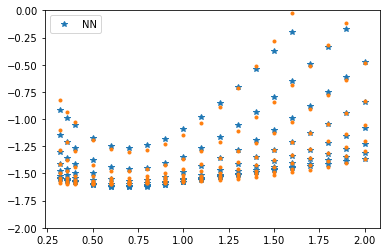

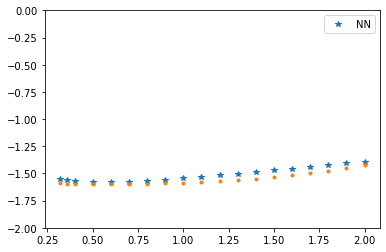

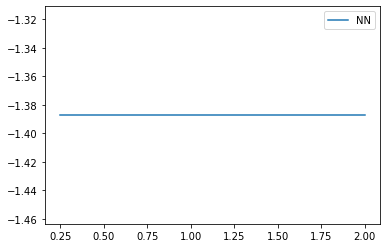

In [17]:
# For example 
print('========Train data==========')
plt.figure()
plt.plot(train_X['Omega'],network.predict(train_X) ,'*',label='NN') 
plt.plot(train_X['Omega'],train_Y,'.')
plt.ylim([-2.0,0])
plt.legend()
print('=======Test data============')
plt.figure()
plt.plot(test_X['Omega'],network.predict(test_X) ,'*',label='NN') 
plt.plot(test_X['Omega'],test_Y,'.')
plt.ylim([-2.0,0])
plt.legend()
# extrapolation
print('=======large Nmax============')
ext_X=np.array([ [i, 20.] for i in np.linspace(0.25,2.0)  ])
plt.figure()
plt.plot(ext_X[:,0],network.predict(ext_X),label='NN') 
plt.legend()

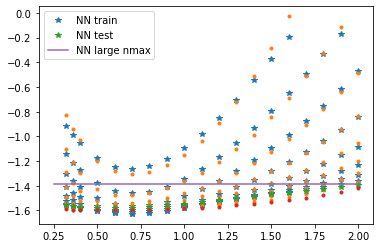

In [18]:
# For example 
plt.figure()
plt.plot(train_X['Omega'],network.predict(train_X) ,'*',label='NN train') 
plt.plot(train_X['Omega'],train_Y,'.')
plt.plot(test_X['Omega'],network.predict(test_X) ,'*',label='NN test') 
plt.plot(test_X['Omega'],test_Y,'.')
# extrapolation
ext_X=np.array([ [i, 10.] for i in np.linspace(0.25,2.0)  ])
plt.plot(ext_X[:,0],network.predict(ext_X),label='NN large nmax') 
plt.legend()

# NCSM 11Be

## Be11 positive parity

In [19]:
#-----read data for positive parity 
Be11p = np.loadtxt('11Be_p.txt')

Be11p_omega = Be11p[1:,0]
Be11p_nmax = Be11p[0,1:]
Be11p_data = Be11p[1:,1:]

#====collect data in table form 
Be11p_df = [] 
for i in range(len(Be11p_omega)):
    for j in range(len(Be11p_nmax)):
        Be11p_df.append([Be11p_omega[i],Be11p_nmax[j],Be11p_data[i,j]])
Be11p_df = pd.DataFrame.from_records(Be11p_df,columns=['Omega', 'Nmax', 'gs' ])

#--discard positive b.e.
Be11p_df = Be11p_df[Be11p_df['gs']<0.0]

Be11p_df.describe()

,Omega,Nmax,gs
count,77.000000,77.000000,77.000000
mean,21.655844,5.909091,-44.480371
std,10.184243,3.052962,16.278576
min,8.000000,1.000000,-64.399600
25%,12.500000,3.000000,-58.469300
50%,20.000000,7.000000,-48.388400
75%,30.000000,9.000000,-34.339500
max,45.000000,11.000000,-5.143900


In [20]:
#---scale and split data
#scaling data 
Be11p_scale_omega = 20.0
Be11p_df['Omega'] = Be11p_df['Omega']/Be11p_scale_omega
Be11p_scale_nmax = 7.0
Be11p_df['Nmax'] = Be11p_df['Nmax']/Be11p_scale_nmax
Be11p_scale_gs = 40.0 
Be11p_df['gs'] = Be11p_df['gs']/Be11p_scale_gs

#--split training and test
Be11p_train_df = Be11p_df[(Be11p_df['Nmax']<11/Be11p_scale_nmax)]
Be11p_test_df = Be11p_df[(Be11p_df['Nmax']==11/Be11p_scale_nmax)]

# random shuffle
Be11p_train_df = Be11p_train_df.sample(frac = 1) 
Be11p_test_df = Be11p_test_df.sample(frac = 1)  

# separate features and labels 
Be11p_train_X = Be11p_train_df.iloc[:,:-1]
Be11p_train_Y = Be11p_train_df.iloc[:,-1]

Be11p_test_X = Be11p_test_df.iloc[:,:-1]
Be11p_test_Y = Be11p_test_df.iloc[:,-1]

Be11p_df.describe()

,Omega,Nmax,gs
count,77.000000,77.000000,77.000000
mean,1.082792,0.844156,-1.112009
std,0.509212,0.436137,0.406964
min,0.400000,0.142857,-1.609990
25%,0.625000,0.428571,-1.461732
50%,1.000000,1.000000,-1.209710
75%,1.500000,1.285714,-0.858488
max,2.250000,1.571429,-0.128598


In [21]:
Be11p_NN = models.Sequential()
Be11p_NN.add(layers.Dense(8, activation='tanh', input_shape=(2,)))
Be11p_NN.add(layers.Dense(1, activation=None))

Be11p_NN.compile(optimizer='Adam',
               loss='MSE')
Be11p_NN.summary()

Be11p_NN.fit(Be11p_train_X, Be11p_train_Y, epochs=4000, batch_size=50, verbose=False)
print('MSE(train)= {}'.format(Be11p_NN.evaluate(Be11p_train_X,Be11p_train_Y)*Be11p_scale_gs ))
print('MSE(test)= {}'.format( Be11p_NN.evaluate(Be11p_test_X,Be11p_test_Y)*Be11p_scale_gs ))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
3/3 [==============================] - 0s 664us/step - loss: 4.6092e-04
MSE(train)= 0.018436789978295565
1/1 [==============================] - 0s 3ms/step - loss: 5.2432e-04
MSE(test)= 0.020972874481230974


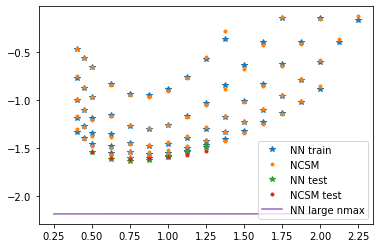

In [22]:
# For example 
plt.figure()
plt.plot(Be11p_train_X['Omega'],Be11p_NN.predict(Be11p_train_X) ,'*',label='NN train') 
plt.plot(Be11p_train_X['Omega'],Be11p_train_Y,'.',label='NCSM')
plt.plot(Be11p_test_X['Omega'],Be11p_NN.predict(Be11p_test_X) ,'*',label='NN test') 
plt.plot(Be11p_test_X['Omega'],Be11p_test_Y,'.',label='NCSM test')
# extrapolation
ext_X=np.array([ [i, 20.] for i in np.linspace(0.25,2.0)  ])
plt.plot(ext_X[:,0],Be11p_NN.predict(ext_X),label='NN large nmax') 
plt.legend()

## Be11 negative parity

In [23]:
#-----read data for negative parity
Be11m = np.loadtxt('11Be_m.txt')

Be11m_omega = Be11m[1:,0]
Be11m_nmax = Be11m[0,2:]
Be11m_data = Be11p[1:,2:]

#====collect data in table form 
Be11m_df = [] 
for i in range(len(Be11m_omega)):
    for j in range(len(Be11m_nmax)):
        Be11m_df.append([Be11m_omega[i],Be11m_nmax[j],Be11m_data[i,j]])
Be11m_df = pd.DataFrame.from_records(Be11m_df,columns=['Omega', 'Nmax', 'gs' ])

#--discard positive b.e.
Be11m_df = Be11m_df[Be11m_df['gs']<0.0]

Be11m_df.describe()

,Omega,Nmax,gs
count,67.000000,67.000000,67.000000
mean,22.395522,5.641791,-46.968685
std,10.422345,2.556640,15.665715
min,8.000000,2.000000,-64.399600
25%,12.500000,4.000000,-59.198450
50%,22.500000,6.000000,-51.189100
75%,30.000000,8.000000,-39.147300
max,45.000000,10.000000,-5.143900


In [24]:
#---scale and split data
#scaling data 
Be11m_scale_omega = 20.0
Be11m_df['Omega'] = Be11m_df['Omega']/Be11m_scale_omega
Be11m_scale_nmax = 7.0
Be11m_df['Nmax'] = Be11m_df['Nmax']/Be11m_scale_nmax
Be11m_scale_gs = 40.0 
Be11m_df['gs'] = Be11m_df['gs']/Be11m_scale_gs

#--split training and test
Be11m_train_df = Be11m_df[(Be11m_df['Nmax']<10/Be11m_scale_nmax)]
Be11m_test_df = Be11m_df[(Be11m_df['Nmax']==10/Be11m_scale_nmax)]

# random shuffle
Be11m_train_df = Be11m_train_df.sample(frac = 1) 
Be11m_test_df = Be11m_test_df.sample(frac = 1)  

# separate features and labels 
Be11m_train_X = Be11m_train_df.iloc[:,:-1]
Be11m_train_Y = Be11m_train_df.iloc[:,-1]

Be11m_test_X = Be11m_test_df.iloc[:,:-1]
Be11m_test_Y = Be11m_test_df.iloc[:,-1]

Be11m_df.describe()

,Omega,Nmax,gs
count,67.000000,67.000000,67.000000
mean,1.119776,0.805970,-1.174217
std,0.521117,0.365234,0.391643
min,0.400000,0.285714,-1.609990
25%,0.625000,0.571429,-1.479961
50%,1.125000,0.857143,-1.279728
75%,1.500000,1.142857,-0.978683
max,2.250000,1.428571,-0.128598


In [25]:
Be11m_NN = models.Sequential()
Be11m_NN.add(layers.Dense(10, activation='tanh', input_shape=(2,)))
Be11m_NN.add(layers.Dense(1, activation=None))

Be11m_NN.compile(optimizer='Adam',
               loss='MSE')

Be11m_NN.summary()

Be11m_NN.fit(Be11m_train_X, Be11m_train_Y, epochs=3000, batch_size=50, verbose=False)
print( Be11m_NN.evaluate(Be11m_train_X,Be11m_train_Y) )
print( Be11m_NN.evaluate(Be11m_test_X,Be11m_test_Y) )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 513us/step - loss: 0.0045
0.004531890153884888
1/1 [==============================] - 0s 998us/step - loss: 0.0116
0.01160773728042841


========Train data==========
=======large Nmax============


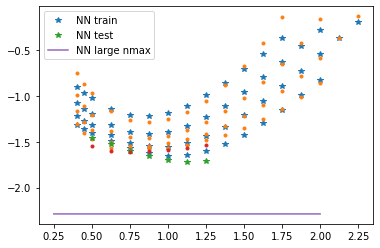

In [26]:
# For example 
print('========Train data==========')
plt.figure()
plt.plot(Be11m_train_X['Omega'],Be11m_NN.predict(Be11m_train_X) ,'*',label='NN train') 
plt.plot(Be11m_train_X['Omega'],Be11m_train_Y,'.')
plt.plot(Be11m_test_X['Omega'],Be11m_NN.predict(Be11m_test_X) ,'*',label='NN test') 
plt.plot(Be11m_test_X['Omega'],Be11m_test_Y,'.')
# extrapolation
print('=======large Nmax============')
ext_X=np.array([ [i, 30.] for i in np.linspace(0.25,2.0)  ])
plt.plot(ext_X[:,0],Be11m_NN.predict(ext_X),label='NN large nmax') 
plt.legend()